# U-Net

Модель U-Net — это простая полностью сверточная нейронная сеть, которая используется для бинарной сегментации, т. е. классификации переднего плана и фона по пикселям. В основном состоит из двух частей.

*   Contracting Path: мы применяем серию конверсионных слоев и слоев понижающей дискретизации (максимальное объединение) слоев, чтобы уменьшить пространственный размер.
*   Expanding Path: мы применяем серию слоев повышения дискретизации для восстановления пространственного размера входных данных.

Две части соединяются с помощью слоев конкатенации между разными уровнями. Это позволяет изучать различные функции на разных уровнях. В конце у нас есть простой слой conv 1x1, чтобы уменьшить количество каналов до 1.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

# Датасет

Мы будем использовать набор данных домашних животных Oxford-IIIT. Он содержит 37 классов собак и кошек, по 200 изображений на каждый класс. Набор данных содержит метки в виде ограничивающих рамок и масок сегментации. Общее количество изображений в датасете 7349 картинок.

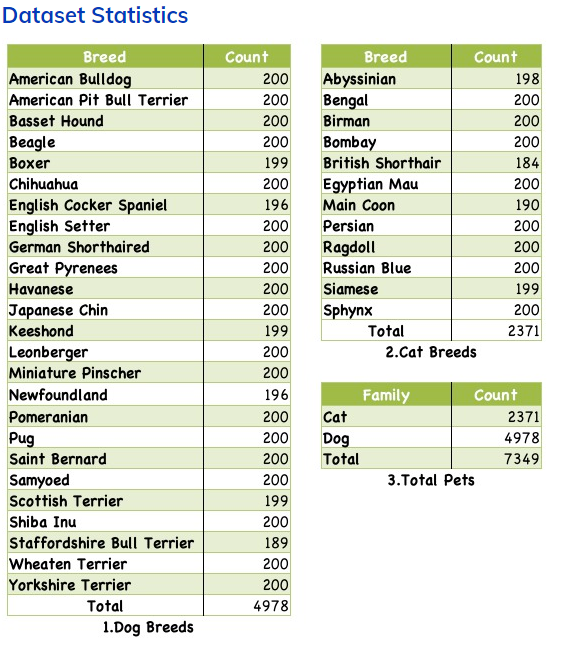

# Загружаем *изображения* и *маски*

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

Выходные данные были обрезаны до нескольких последних строк (5000).
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/t

# Генераторы

In [ ]:
def image_generator(files, batch_size = 32, sz = (256, 256)):

  while True:

    #получение случайной выборки
    batch = np.random.choice(files, size = batch_size)

    #переменные для сбора выборок: входов и выходов
    batch_x = []
    batch_y = []


    for f in batch:

        #получение масок
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #предварительная обработака масок
        mask[mask >= 2] = 0
        mask[mask != 0 ] = 1

        batch_y.append(mask)

        #предварительная обработка необработанных изображений
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #проверка кол-ва каналов, т.к. есть цветные и ч/б картинки
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)


In [ ]:
batch_size = 32

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#разделение на тренировочную и тестовую
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [ ]:
x, y= next(train_generator)

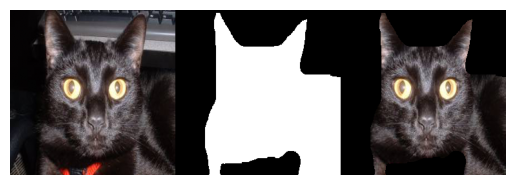

In [ ]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Модель

In [ ]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x

  f = 8
  layers = []

  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64

  #повышающая дискретизация
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1

  #upsampling
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1


  #классификация
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)

  #Создание модели
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])

  return model

In [ ]:
model = unet()

# Вызов

Простые функции для сохранения модели в каждую эпоху и показа некоторых прогнозов

In [ ]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

#наследование для тренировочного процесса
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))

        #выбрать случайное тестовое изображение и выполнить предварительную обработку
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]

        #предсказание маски
        pred = model.predict(np.expand_dims(raw, 0))

        #постобработка маски
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1
        msk[msk < 0.5] = 0

        #вывод маски и сегментированного изображения
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Tренировка

In [ ]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator,
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Тест на изображении

In [ ]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2023-05-14 12:22:00--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 108.156.120.17, 108.156.120.82, 108.156.120.96, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|108.156.120.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.01s   

2023-05-14 12:22:00 (4.80 MB/s) - ‘test.jpg’ saved [63219/63219]



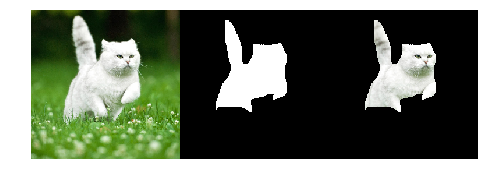

In [ ]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#предсказание маски
pred = model.predict(np.expand_dims(raw, 0))

#постобработка маски
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1
msk[msk < 0.5] = 0

#вывод изображения
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# Создание новой модели MobileNetV2

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 52.8 MB/s eta 0:00:00


In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZEETUF/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZEETUF/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def normalize(image, mask):
  image = tf.cast(image, tf.float32)/255.
  mask -=1
  return image, mask

@tf.function
def load_image_train(data):
  image = tf.image.resize(data['image'], (128,128))
  mask = tf.image.resize(data['segmentation_mask'], (128,128))

  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)

  image, mask = normalize(image, mask)
  return image, mask

def load_image_test(data):
  image = tf.image.resize(data['image'], (128,128))
  mask = tf.image.resize(data['segmentation_mask'], (128,128))

  image, mask = normalize(image, mask)
  return image, mask

In [ ]:
info.splits['train'].num_examples, info.splits['test'].num_examples

(3680, 3669)

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH / BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15,15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

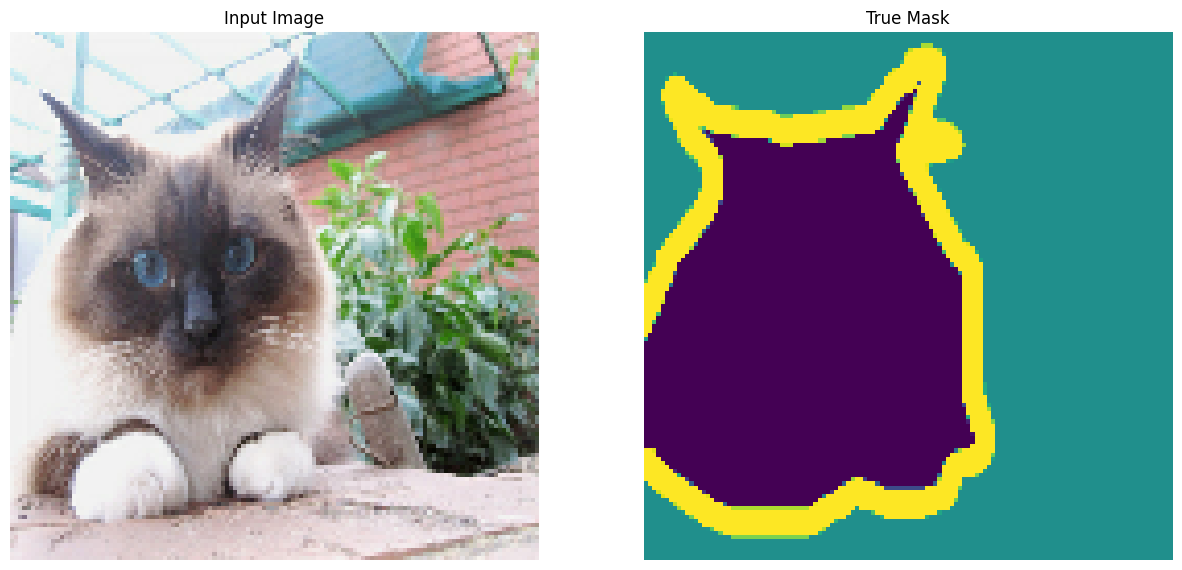

In [ ]:
for image, mask in train.take(11):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Используемая здесь модель - это модифицированная U-Net. MobileNetV2
U-net состоит из кодера (понижающего усилителя) и декодера (повышающего усилителя). Для того чтобы выучить надежные характеристики и уменьшить количество обучаемых параметров, в качестве кодера можно использовать предварительно обученную модель. Таким образом, в качестве кодера для данной задачи будет использоваться предварительно обученная модель MobileNetV2, промежуточные выходы которой будут использоваться.

Причина вывода трех каналов заключается в том, что для каждого пикселя существует три возможных метки.

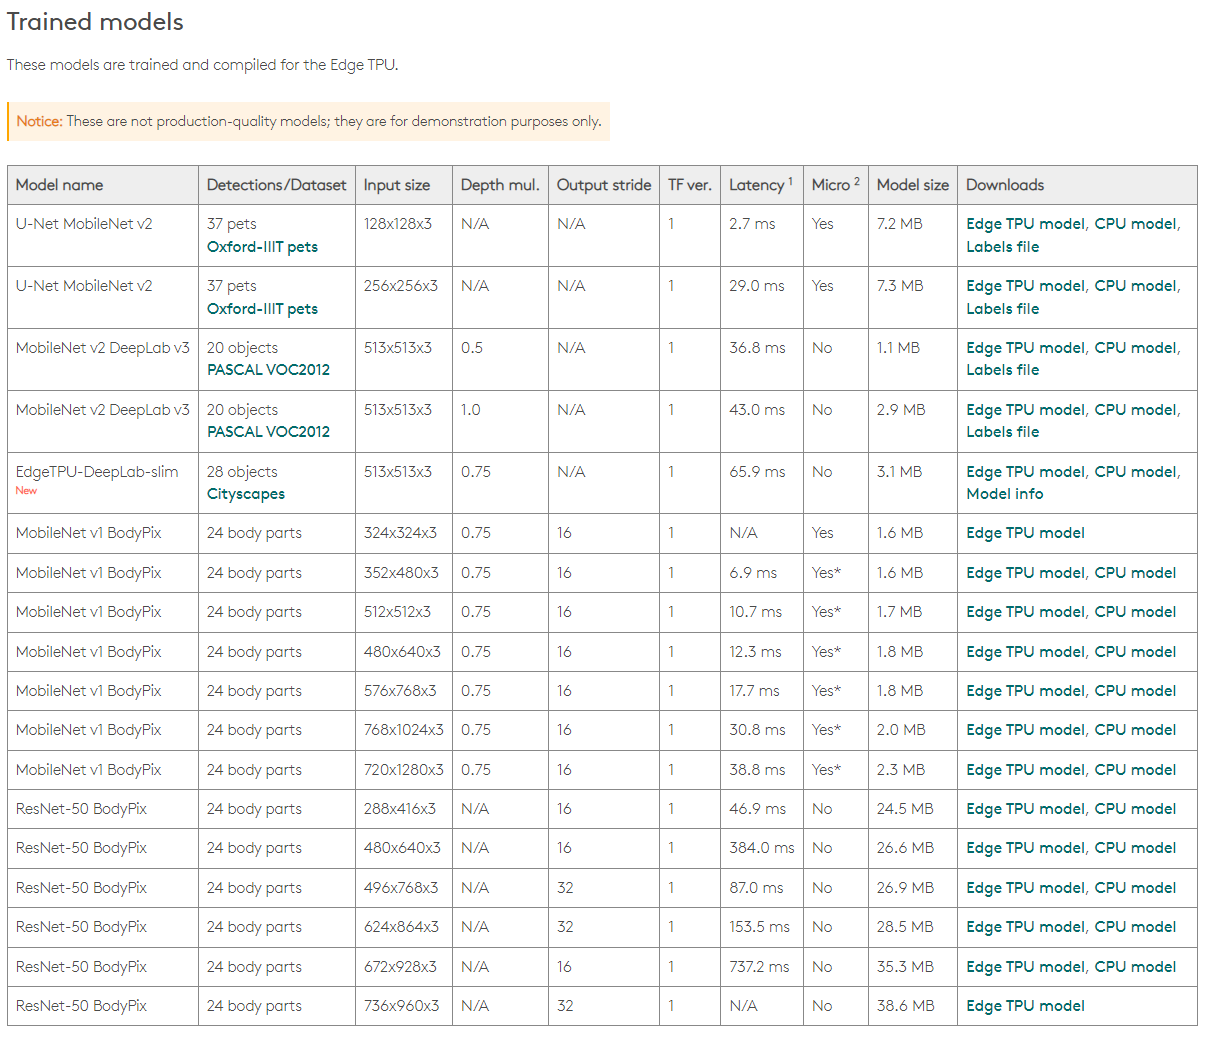

Слева нарисован блок обычной сверточной сети, а справа — базовый блок MobileNet.
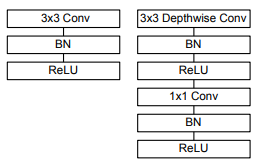

Сверточная часть интересующей нас сети состоит из одного обычного свёрточного слоя с 3х3 свёрткой в начале и тринадцати блоков, изображенных справа на рисунке, с постепенно увеличивающимся числом фильтров и понижающейся пространственной размерностью тензора.

Особенностью данной архитектуры является отсутствие max pooling-слоёв. Вместо них для снижения пространственной размерности используется свёртка с параметром stride, равным 2.

Двумя гиперпараметрами архитектуры MobileNet являются $\alpha$ (множитель ширины) и $\rho$ (множитель глубины или множитель разрешения).

Множитель ширины отвечает за количество каналов в каждом слое. Например, $\alpha = 1$ даёт нам архитектуру, описанную в статье, а $\alpha = 0.25$ — архитектуру с уменьшенным в четыре раза числом каналов на выходе каждого блока.

Множитель разрешения отвечает за пространственные размеры входных тензоров. Например, $\rho= 0.5$ означает, что высота и ширина feature map, подаваемой на вход каждому слою будет уменьшена вдвое.

Оба параметра позволяют варьировать размеры сети: уменьшая $\alpha$ и $\rho$, мы снижаем точность распознавания, но в то же время увеличиваем скорость работы и уменьшаем потребляемую память.

MobileNetV2 — следующее поколение нейросетей этого семейства, которое позволяет достигать примерно такой же точности распознавания при ещё большей скорости работы.

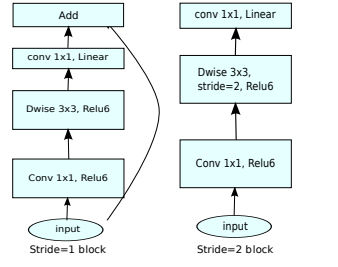

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3), include_top=False)

names = ['block_1_expand_relu', 'block_3_expand_relu', 'block_6_expand_relu',
         'block_13_expand_relu', 'block_16_expand_relu']
layers = [base_model.get_layer(name).output for name in names]

down_sample = tf.keras.Model(base_model.input, layers)
down_sample.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

## Модель и результаты

In [ ]:
inputs = tf.keras.layers.Input(shape=[128,128,3 ])
x = inputs

# Downsampling through the model
skips = down_sample(x)
x = skips[-1]
skips = reversed(skips[:-1])

# Upsampling and establishing the skip connections
for up, skip in zip(up_stack, skips):
  x = up(x)
  concat = tf.keras.layers.Concatenate()
  x = concat([x, skip])

# This is the last layer of the model
x = tf.keras.layers.Conv2DTranspose(3, 3, strides=2 , padding='same')(x)  #64x64 -> 128x128

model = tf.keras.Model(inputs, x)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 11s 11s/step


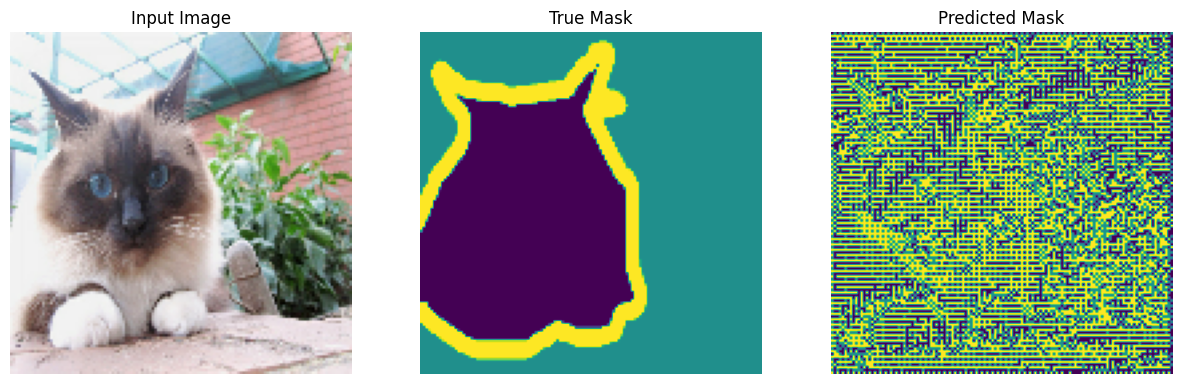

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()

1/1 [==============================] - 0s 23ms/step


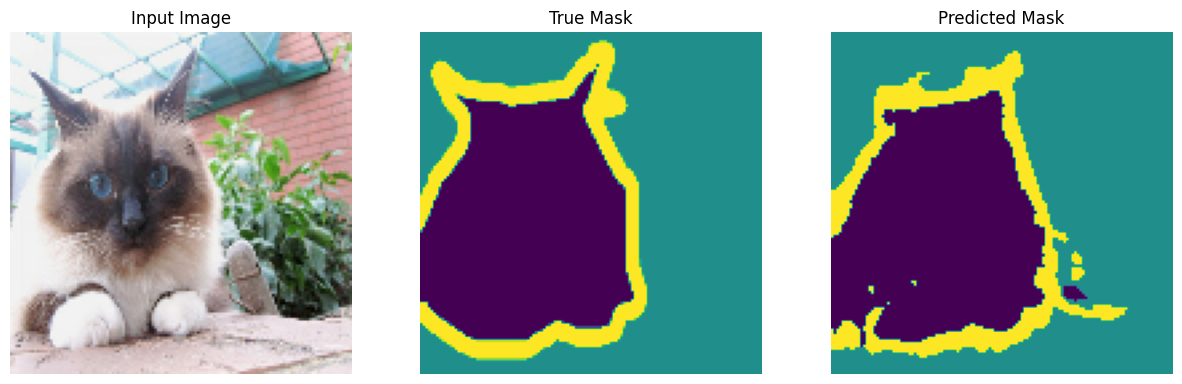

57/57 [==============================] - 20s 349ms/step - loss: 0.0529 - accuracy: 0.9698 - val_loss: 0.5505 - val_accuracy: 0.8842


In [ ]:
EPOCHS =  20

h = model.fit(train_dataset,
              epochs=EPOCHS,
              steps_per_epoch=STEPS_PER_EPOCH,
              validation_data=test_dataset,
              callbacks=[DisplayCallback()])

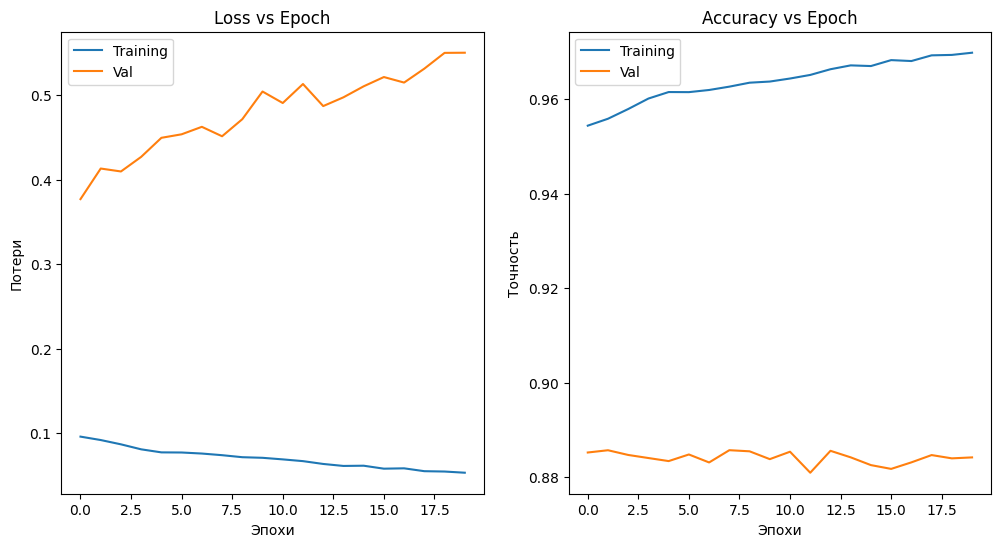

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(h.history['loss'], label='Training')
plt.plot(h.history['val_loss'], label='Val')
plt.title('Loss vs Epoch')
plt.legend()
plt.ylabel('Потери')
plt.xlabel('Эпохи')

plt.subplot(1,2,2)
plt.plot(h.history['accuracy'], label='Training')
plt.plot(h.history['val_accuracy'], label='Val')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.ylabel('Точность')
plt.xlabel('Эпохи')
plt.show()

# Результаты на данных

2/2 [==============================] - 0s 45ms/step


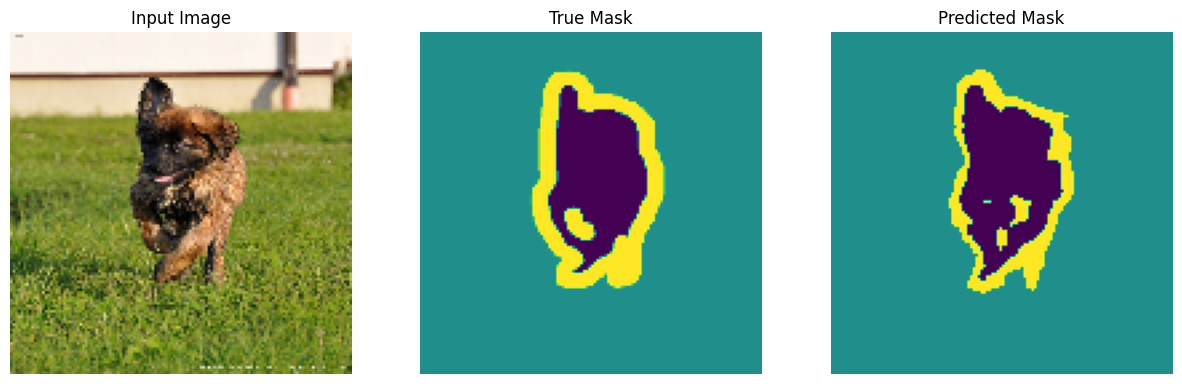

2/2 [==============================] - 0s 44ms/step


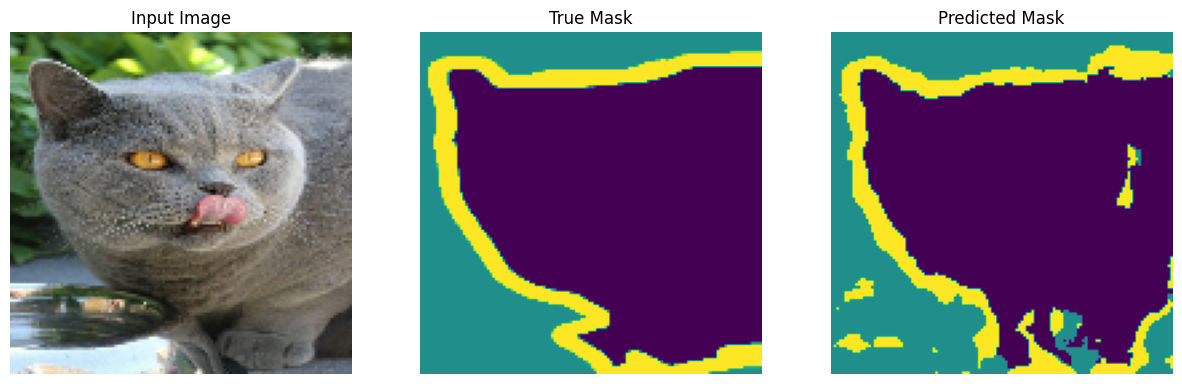

In [ ]:
show_predictions(test_dataset, 2)